# How do we define 'good' synthetic data?
In general, we hope a 'good' synthetic data to ensure optimum utility whilst not compromising privacy. We mainly evaluate our synthetic data from the following points.  

* **Distribution** — the synthetic data should 
    * capture the diversity, distribution between variables of the original data.
    * capture dependencies between variables of the original data.
* **Fidelity** — samples should be indistinguishable from the real data.
* **Usefulness** —synthetic data should be just as useful as the real data when used for the same predictive purposes. There are two different tasks, and hense we use different evalution methods for each task.
    * The synthetic data is used to train a model, which then will be deployed on real data. In this case, we apply TSTR (train on synthetic data and test on real data) and see how well the model performs.
    * The synthetic data is used to identify the best methods to use on the real data. In this case, we apply TSTS&TRTR and see if the model performs equally well on synthetic data and real data.
* **Privacy** – No real individual should be identifiable from the synthetic data.  

20% of the original data, not used in the generative model, is used for the evaluation methods (original evaluation sample). An equal size of the synthetic data is used for comparison (synthetic evaluation sample).

## 1 Distribution
### 1.1 Histogram for each _numerical_ column
This method is used to compare how similar the **diversity and distribution** of a _numerical_ variable (column).

ori_df is original from cat_time_5abovevisits_all.csv.
gen_1_df is original from gen_cat_time_10visits_wl_5000it_hd10_nl5.npy.
gen_2_df is original from gen_cat_time_10visits_wl_5000it_hd10.
gen_3_df is original from gen_dop_cat_5abovevisits_d2g_e449.

In [40]:
#load the data
import numpy as np
import pandas as pd
ori_df = pd.read_csv('synthetic data/2_no_id/ori_df.csv')
gen_1_df = pd.read_csv('synthetic data/2_no_id/gen_1_df.csv')
gen_2_df = pd.read_csv('synthetic data/2_no_id/gen_2_df.csv')
gen_3_df = pd.read_csv('synthetic data/2_no_id/gen_3_df.csv')

In [61]:
dp_ori_df = pd.read_csv('synthetic data/doppelGANger/dp_ori.csv')
dp_gen_df = pd.read_csv('synthetic data/doppelGANger/dp_gen.csv')
tgan_ori_df = pd.read_csv('synthetic data/TGAN/tgan_ori.csv')
tgan_gen_df = pd.read_csv('synthetic data/TGAN/tgan_gen.csv')

In [62]:
#Remove all-zero rows. 
#The data uses all-zero rows to mark as an end to the time sequence and to make the time sequence length for each sample same. 
#However, in this test, we don't need time sequence length to be the same and lots of zeros can result in a heavy bias.
dp_ori_nozero = dp_ori_df[np.any(abs(dp_ori_df)!=0,axis=1)].copy()
dp_gen_nozero = dp_gen_df[np.any(abs(dp_gen_df)!=0,axis=1)].copy()
tgan_ori_nozero = tgan_ori_df[np.any(abs(tgan_ori_df)!=0,axis=1)].copy()
tgan_gen_nozero = tgan_gen_df[np.any(abs(tgan_gen_df)!=0,axis=1)].copy()

For each numerical column, we draw two histograms for values from real and synthetic data in the same plot. The histogram can be viewed as a pdf (probability density function) plot. We also plot the corresponding cdf (cumulative density function).  

By viewing the graph we can have a subjective idea about how similar the distributions are. However, We also wish to compare similarity numerically. We apply <!-- [Text](link) -->
[Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test "Optional Title")
. It is a hypothesis test which the null test is the two samples are drawn from the same distribution.

In [21]:
def Histogram_KSTest(ori_nozero,gen_nozero,size = 100):
    keys = (ori_nozero.keys()).tolist()
    n = len(keys)
    l = min(len(ori_nozero),len(gen_nozero))

    import matplotlib.pyplot as plt
    from scipy import stats
    
    p_value = np.zeros(n)
    for num in range(n):
        name = keys[num]
        ser_ori = ori_nozero[name].values[:l]
        ser_gen = gen_nozero[name].values[:l]
        df= pd.DataFrame({'ori':ser_ori, 'gen':ser_gen})
        df.plot.hist(bins=100,alpha=0.5,cumulative=False)
        plt.title(name+'_pdf')
        df.plot.hist(bins=100,alpha=0.5,cumulative=True,histtype='step')
        plt.title(name+'_cdf')
        plt.show()

        value = [0,0]
        for k in range(10):
        #Randomly take 100 samples from the generated and real data, since the total sample size is 40,000+, which is too
        #large and the null hypothesis can get easily rejected, which actually doesn't make statistical sense.
            idx = np.random.permutation(l)
            idx = idx[:size]
            name = keys[num]
            ser_ori = ori_nozero[name].values[idx]
            ser_gen = gen_nozero[name].values[idx]
            (t,p) = stats.ks_2samp(ser_ori, ser_gen)
            value[0] = value[0]+t
            value[1] = value[1]+p
        value = np.array(value)/10
        p_value[num] = value[1]
        print('K-S test result:',value) #the displayed array is the average (statistic, p_value), the closer to 0 the p is
        #the null hypothesis is more likely to be rejected.
    p_series = pd.Series(p_value, index = keys)
    return p_series



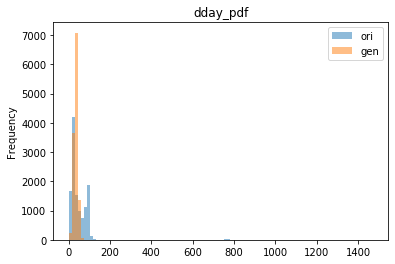

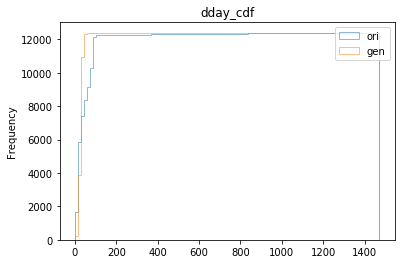

K-S test result: [0.377      0.00000967]


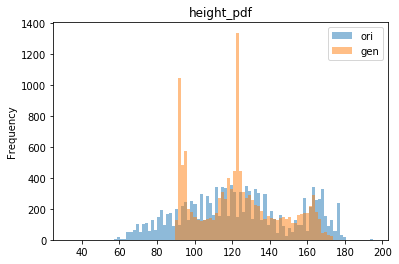

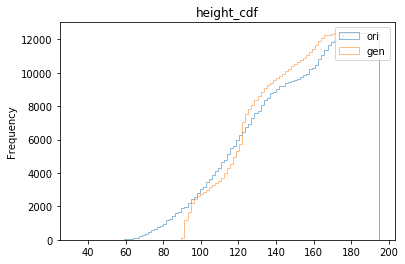

K-S test result: [0.184      0.14711805]


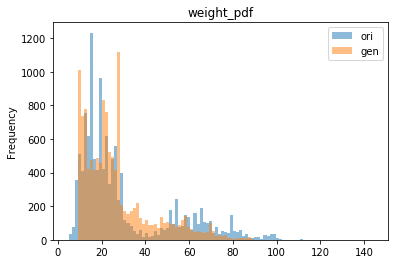

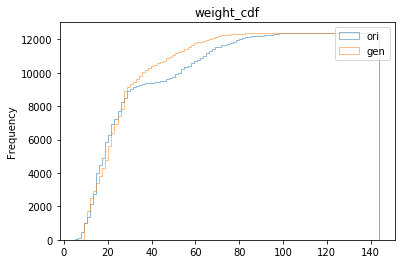

K-S test result: [0.151      0.35454207]


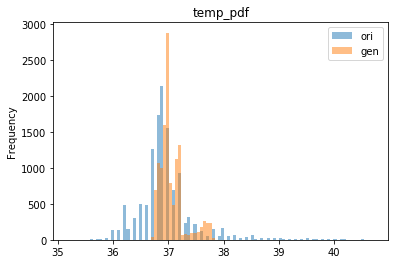

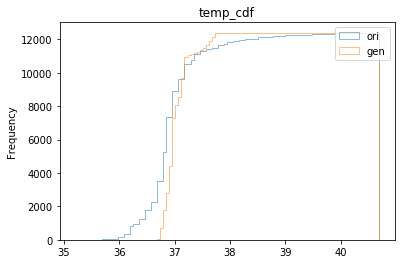

K-S test result: [0.374     0.0000202]


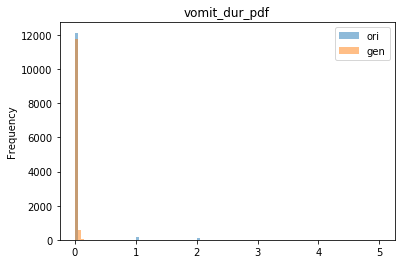

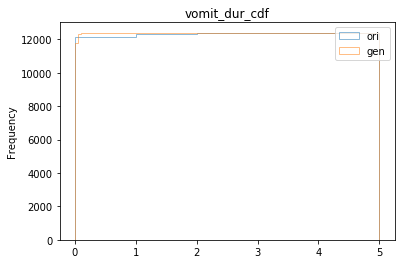

K-S test result: [0.98 0.  ]


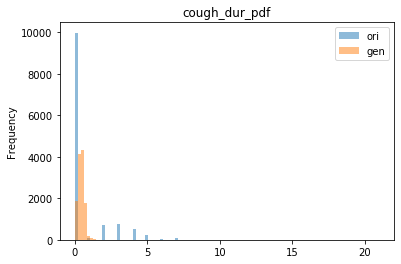

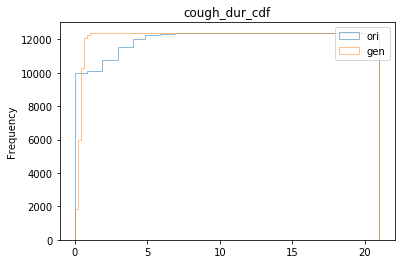

K-S test result: [0.812 0.   ]


dday         9.668481e-06
height       1.471180e-01
weight       3.545421e-01
temp         2.020498e-05
vomit_dur    1.488092e-52
cough_dur    1.617494e-29
dtype: float64

In [25]:
#Implement with doppelGANger synthetic data and the corresponding real data.
p_series1 = Histogram_KSTest(ori_df.iloc[:,:6],gen_1_df.iloc[:,:6])
np.set_printoptions(suppress = True)
display(p_series1)

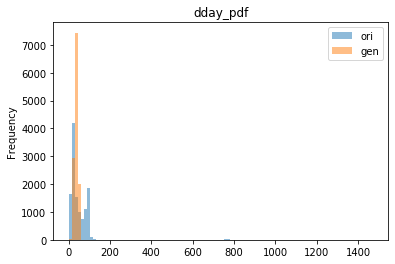

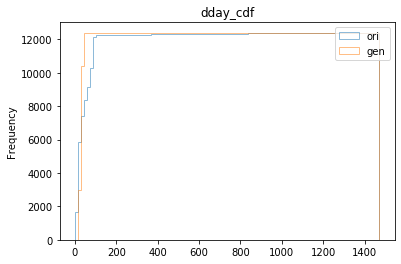

K-S test result: [0.388      0.00000211]


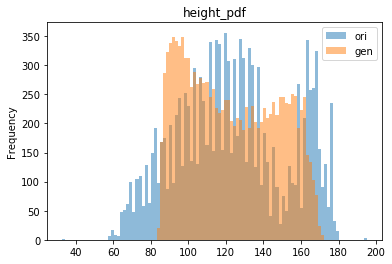

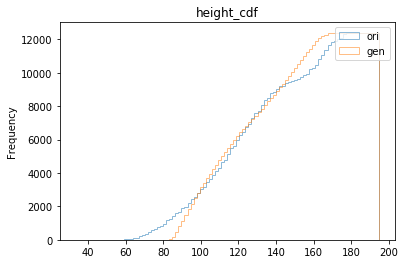

K-S test result: [0.168      0.16730057]


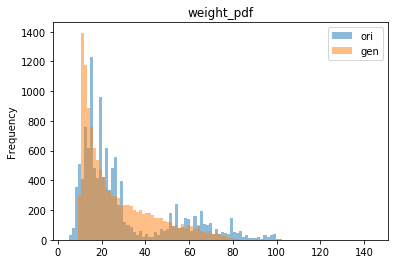

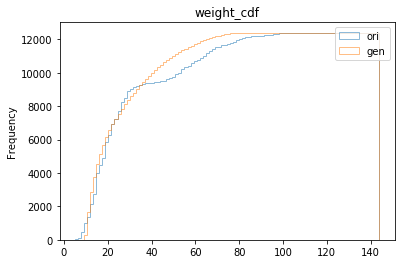

K-S test result: [0.169      0.18214458]


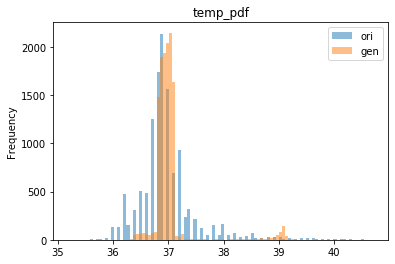

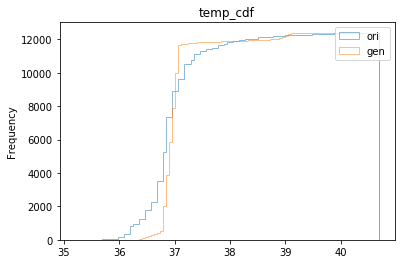

K-S test result: [0.388     0.0000037]


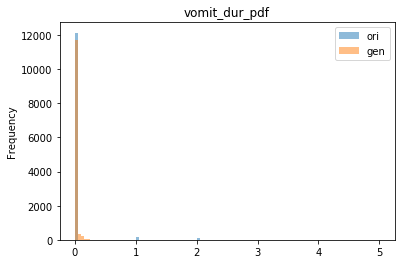

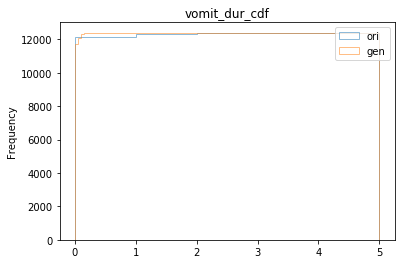

K-S test result: [0.982 0.   ]


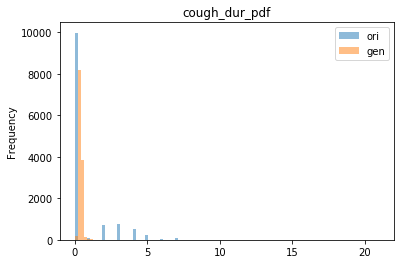

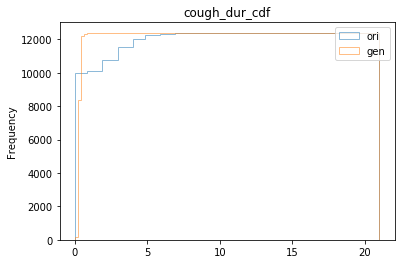

K-S test result: [0.799 0.   ]


dday         2.014200e-06
height       2.468489e-01
weight       3.168757e-01
temp         2.456342e-05
vomit_dur    1.517097e-52
cough_dur    2.241184e-30
dtype: float64

In [24]:
#Implement with doppelGANger synthetic data and the corresponding real data.
p_series2 = Histogram_KSTest(ori_df.iloc[:,:6],gen_2_df.iloc[:,:6])
np.set_printoptions(suppress = True)
display(p_series2)

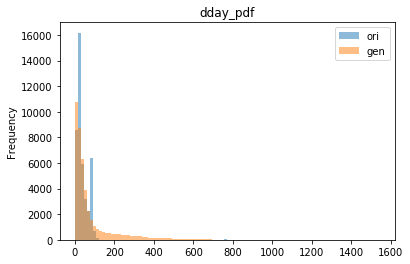

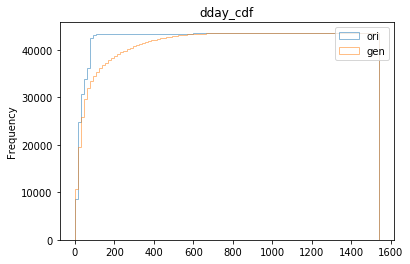

K-S test result: [0.224      0.04393714]


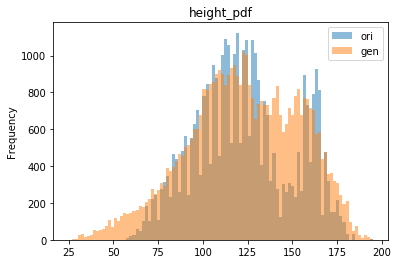

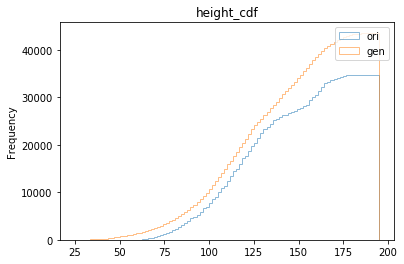

K-S test result: [0.222      0.04515427]


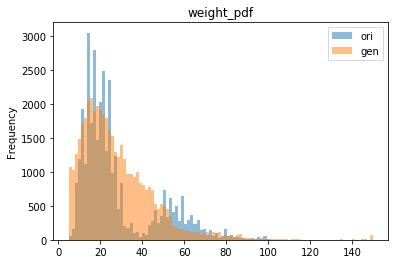

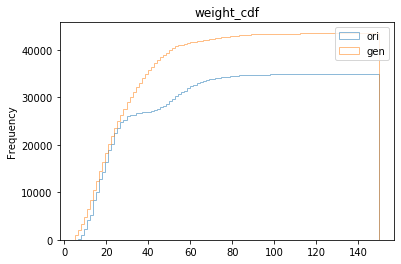

K-S test result: [0.29       0.00208779]


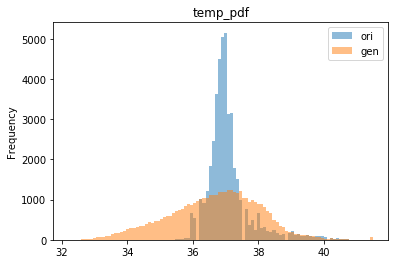

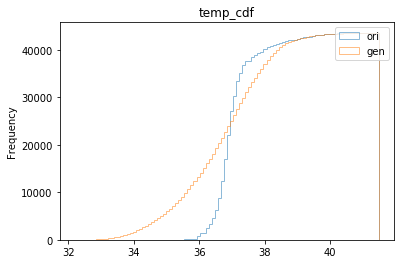

K-S test result: [0.374      0.00011653]


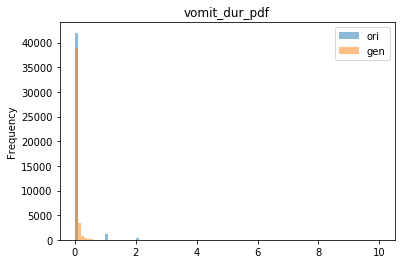

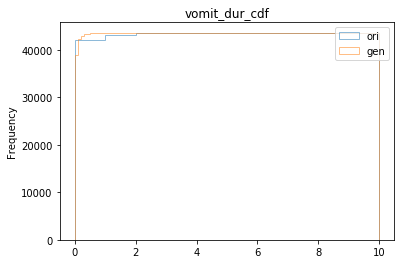

K-S test result: [0.571 0.   ]


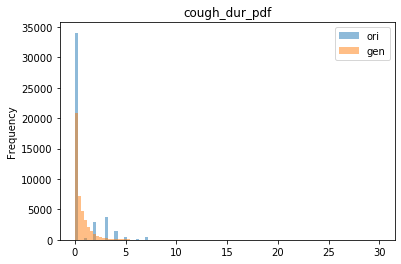

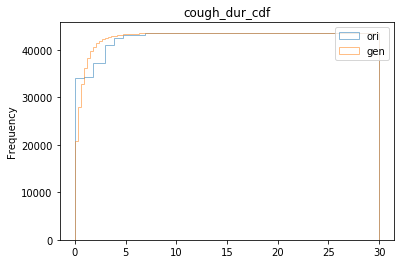

K-S test result: [0.562 0.   ]


dday         4.393714e-02
height       4.515427e-02
weight       2.087788e-03
temp         1.165344e-04
vomit_dur    1.027009e-12
cough_dur    7.268437e-11
dtype: float64

In [26]:
#Implement with doppelGANger synthetic data and the corresponding real data.
p_series3 = Histogram_KSTest(ori_df.iloc[:,:6],gen_3_df.iloc[:,:6])
np.set_printoptions(suppress = True)
display(p_series3)

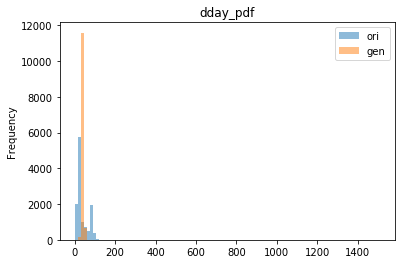

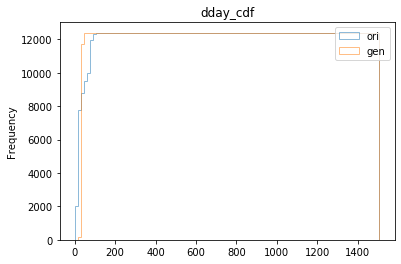

K-S test result: [0.6306 0.    ]


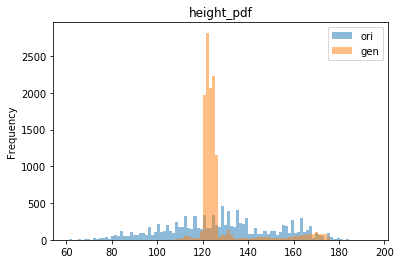

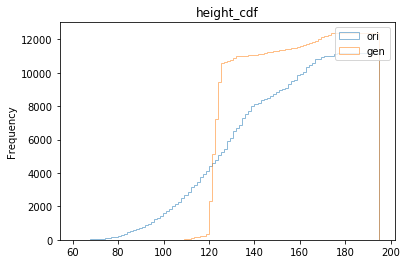

K-S test result: [0.4474 0.    ]


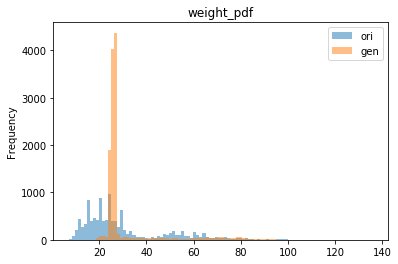

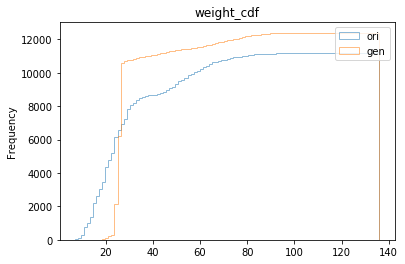

K-S test result: [0.4214 0.    ]


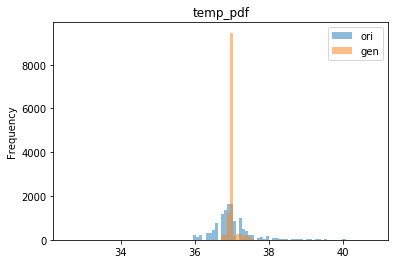

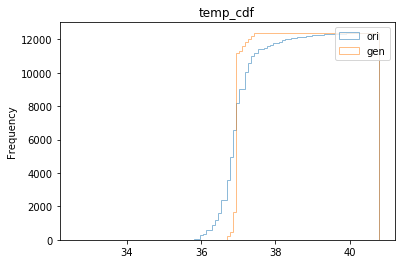

K-S test result: [0.4938 0.    ]


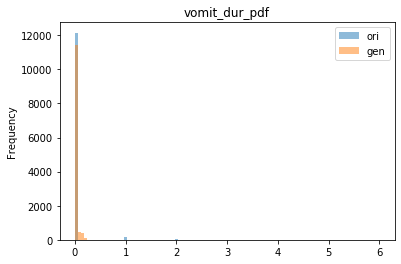

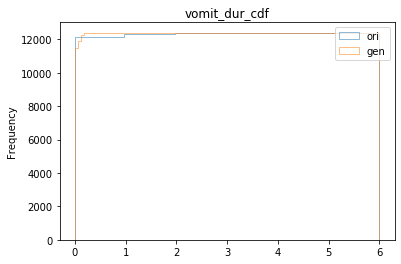

K-S test result: [0.9796 0.    ]


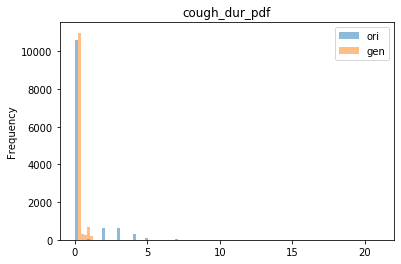

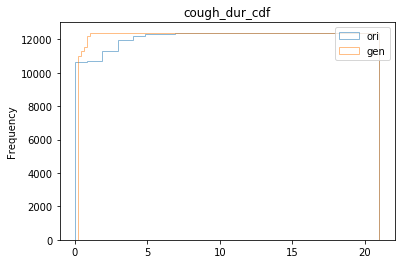

K-S test result: [0.8588 0.    ]


dday          3.030194e-83
height        9.341029e-37
weight        3.606861e-31
temp          4.258242e-49
vomit_dur    3.186398e-266
cough_dur    5.117387e-179
dtype: float64

In [43]:
p_series_tgan = Histogram_KSTest(tgan_ori_nozero.iloc[:,:6],tgan_gen_nozero.iloc[:,:6],size=500)
display(p_series_tgan)

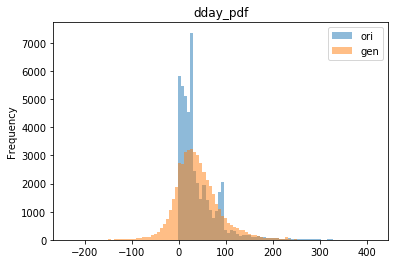

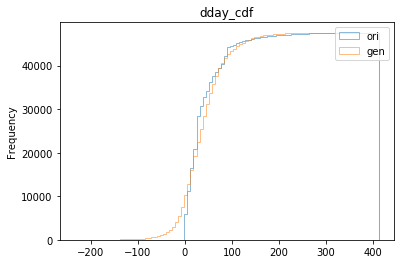

K-S test result: [0.2        0.04933793]


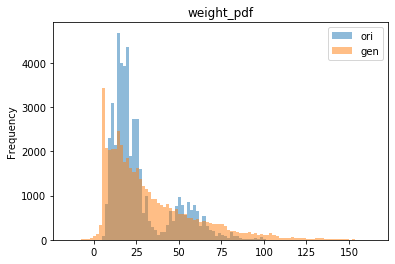

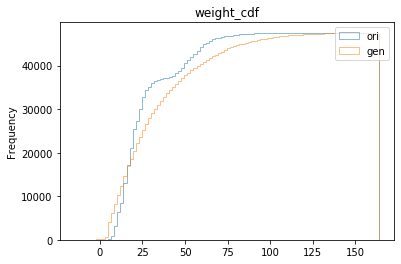

K-S test result: [0.204      0.10165303]


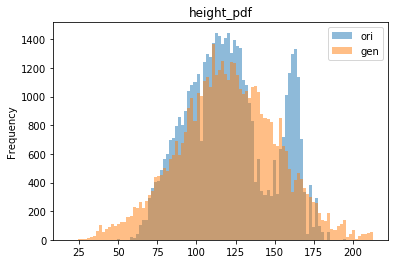

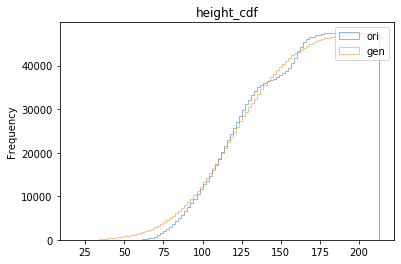

K-S test result: [0.11       0.59765081]


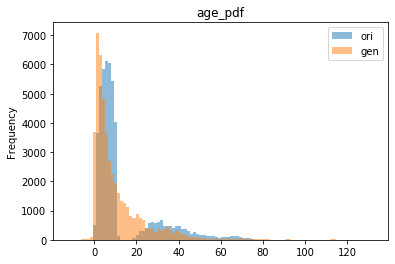

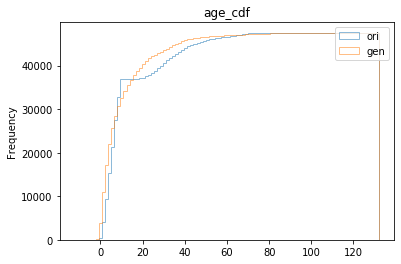

K-S test result: [0.208      0.06429164]


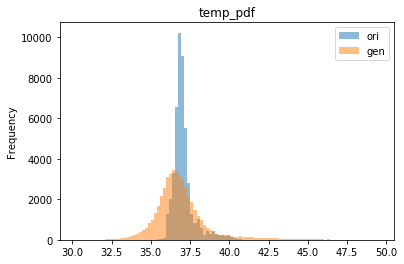

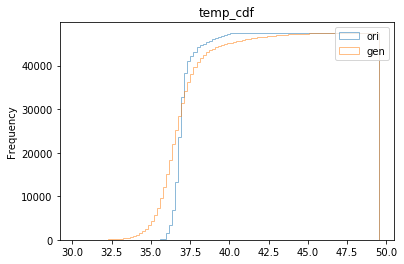

K-S test result: [0.358      0.00020633]


dday      0.049338
weight    0.101653
height    0.597651
age       0.064292
temp      0.000206
dtype: float64

In [44]:
p_series_dp = Histogram_KSTest(dp_ori_nozero,dp_gen_nozero)
display(p_series_dp)

In [45]:
#Compare the p values for all synthetic data
pd.DataFrame({'generated 1':p_series1,'generated 2':p_series2,'generated 3':p_series3,'tgan':p_series_tgan,\
             'dp_ini':p_series_dp})

,generated 1,generated 2,generated 3,tgan,dp_ini
age,NaN,NaN,NaN,NaN,0.064292
cough_dur,1.617494e-29,4.433969e-27,7.268437e-11,5.117387e-179,NaN
dday,9.668481e-06,2.111829e-06,4.393714e-02,3.030194e-83,0.049338
height,1.471180e-01,1.673006e-01,4.515427e-02,9.341029e-37,0.597651
temp,2.020498e-05,3.701132e-06,1.165344e-04,4.258242e-49,0.000206
vomit_dur,1.488092e-52,5.600865e-51,1.027009e-12,3.186398e-266,NaN
weight,3.545421e-01,1.821446e-01,2.087788e-03,3.606861e-31,0.101653


The closer the p to 1, the more similar the distribution of the synthetic data is to the original data. It looks like the initial doppelGANger data is still the best one, generated 1 is better than generated 2, and they are better than generated 3 in height, temp and weight. However, generated 3 is better in dday, cough_dur and vomi_dur.

### 1.2 Scatter plot for _categorical_ columns
This method is used to compare how similar the **diversity and distribution** of a _categorical_ variable (column).  

For One-hot-encoded categorical variables (only TGANs data contains categorical variables now), we hope to plot a scatter graph of the proportion of '1' and '0' in each column in the synthetic data against that in the real data. An ideal synthetic data should lie on the diagonal $ y=x $.

The table below shows the proportion values. Note there are 8 rows but there are only 4 points in the scatter graph. This is because, for example, '0' in diar_No has to mean '1' in diar_Yes logically.

In [91]:

def Scatter_Distance(ori_data, gen_data, syn_name = None):
    #syn_name is the name of the synthetic data generator e.g. 'tGAN'
    import matplotlib.pyplot as plt
    from math import sqrt
    
    #since the categorical variables are OHE, so we regard entries > 0.5 as 1, entries < 0.5 as 0 for gen_data
    gen_data = gen_data[gen_data<0.5].fillna(1)
    gen_data = gen_data[gen_data>0.5].fillna(0)
    
    def CatProportion(series):
        return series.value_counts()/len(series)

    cat_keys = (gen_data.keys()).tolist()
    first = True
    name_index = []
    cat_index = []
    for name in cat_keys:
        df_1=pd.DataFrame({'gen':CatProportion(gen_data[name]),'ori': CatProportion(ori_data[name])})
        if first:
            v = df_1.values
            first = False
        else:
            v = np.concatenate((v,df_1.values),axis = 0)
        df1_index = df_1.index.tolist()
        name_index += [name]*len(df1_index)
        cat_index += df1_index

    df_cat = pd.DataFrame(v, index = [name_index,cat_index], columns = [syn_name+ ' '+'generated',syn_name+' '+'original'])
    df_cat = df_cat.fillna(0)
    display(df_cat)
    plt.scatter(df_cat[syn_name+ ' '+'generated'],df_cat[syn_name+' '+'original'],c = 'r')
    plt.plot([0,1])
    plt.show()
    
    def PtToDiagnalDist(coordinates, aver = True):
        '''
        For a series of points(2D), calculate the distance between each points and the diagonal y=x
        
        Args: 
        coordinates: array in shape (n,2), n is the number of points
        aver: True(default) or False. If aver == True, the distances are averaged, otherwise a list of distances is returned
        
        Returns:
        a: a list of distances, returned when aver==False
        np.sum(a)/n: the average of distances, returned when aver == True
        '''
        n = len(coordinates)
        a = np.zeros(n)
        for i in range(n):
            x = coordinates[i][0]
            y = coordinates[i][1]
            d = abs(x-y)/sqrt(2) #formula to calculate the distance between point (X,Y) and line ax+by+c = 0 is
            # abs(aX+bY+c)/abs(a^2+b^2)
            a[i]=d
        if aver:
            return np.sum(a)/n
        else:
            return a
    distance = PtToDiagnalDist(df_cat.values)
    return distance


tgan generated  tgan original
diar_No  0.0        0.000000       0.022357
         1.0        1.000000       0.977643
diar_Yes 0.0        1.000000       0.977643
         1.0        0.000000       0.022357
head_No  1.0        0.906457       0.889346
         0.0        0.093543       0.110654
head_Yes 0.0        0.906457       0.889346
         1.0        0.093543       0.110654

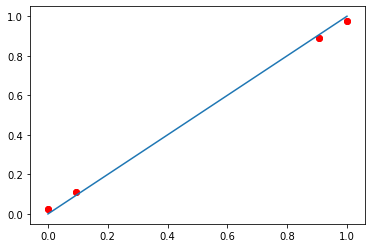

In [92]:
#.._cat means the part of the df only containing categorical variables, we'll process categorical variables plot (Lora's scatterplot) for this.
tgan_ori_cat = tgan_ori_nozero.iloc[:,6:]
tgan_gen_cat = tgan_gen_nozero.iloc[:,6:]
a_tgan = Scatter_Distance(tgan_ori_cat,tgan_gen_cat,syn_name = 'tgan')

In [93]:
a_tgan

0.013953802098475456

1 generated  1 original
diar_No  1.0     0.999193    0.968322
         0.0     0.000807    0.031678
diar_Yes 0.0     0.999193    0.968322
         1.0     0.000807    0.031678
head_No  1.0     0.866667    0.881327
         0.0     0.133333    0.118673
head_Yes 0.0     0.867554    0.881327
         1.0     0.132446    0.118673

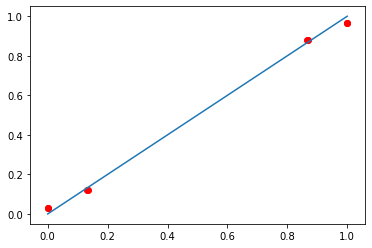

0.015940757488351987

In [96]:
ori_cat = ori_df.iloc[:,6:]
gen_1_cat = gen_1_df.iloc[:,6:]
a_1 = Scatter_Distance(ori_cat,gen_1_cat,syn_name = '1')
display(a_1)

2 generated  2 original
diar_No  1.0     0.992817    0.968322
         0.0     0.007183    0.031678
diar_Yes 0.0     0.995319    0.968322
         1.0     0.004681    0.031678
head_No  1.0     0.902098    0.881327
         0.0     0.097902    0.118673
head_Yes 0.0     0.902260    0.881327
         1.0     0.097740    0.118673

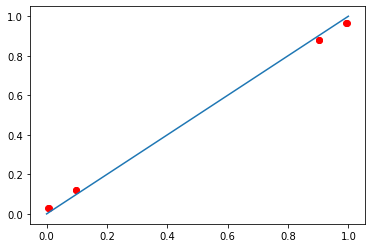

0.016474649086402608

In [97]:
gen_2_cat = gen_2_df.iloc[:,6:]
a_2 = Scatter_Distance(ori_cat,gen_2_cat,syn_name = '2')
display(a_2)

3 generated  3 original
diar_No  1.0     0.988742    0.968322
         0.0     0.011258    0.031678
diar_Yes 0.0     0.988742    0.968322
         1.0     0.011258    0.031678
head_No  1.0     0.947447    0.881327
         0.0     0.052553    0.118673
head_Yes 0.0     0.947447    0.881327
         1.0     0.052553    0.118673

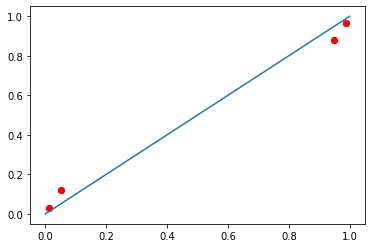

0.030596200016738274

In [98]:
gen_3_cat = gen_3_df.iloc[:,6:]
a_3 = Scatter_Distance(ori_cat,gen_3_cat,syn_name = '3')
display(a_3)

In [100]:
display(pd.Series([a_tgan,a_1,a_2,a_3],index = ['tgan','1','2','3']))

tgan    0.013954
1       0.015941
2       0.016475
3       0.030596
dtype: float64

Though tgan gives the least distance value, but it completely ignores diar_Yes, so we'll conclude that gen_1 gives the best performance in this test.

**Reference:**
* <!--[Text](link)-->
[Ramiro D. Camino, Christian A. Hammerschmidt, Radu State.Generating Multi-Categorical Samples with Generative Adversarial Networks](https://arxiv.org/pdf/1807.01202.pdf)

In [15]:
a = np.zeros(5)
a[0] = 0.3
display(a)

array([0.3, 0. , 0. , 0. , 0. ])